Reloading Tuner from hyperband\cnn_lstm_hyperparameter_tuning\tuner0.json


d:\Capstone\El Nino\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Capstone\El Nino\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'filters': 96, 'kernel_size': 2, 'lstm_units': 100, 'learning_rate': 0.0026717627791811426, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Best CNN-LSTM RMSE: 0.1140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\rumma\AppData\Local\Temp\ipykernel_10988\2855138916.py:134: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


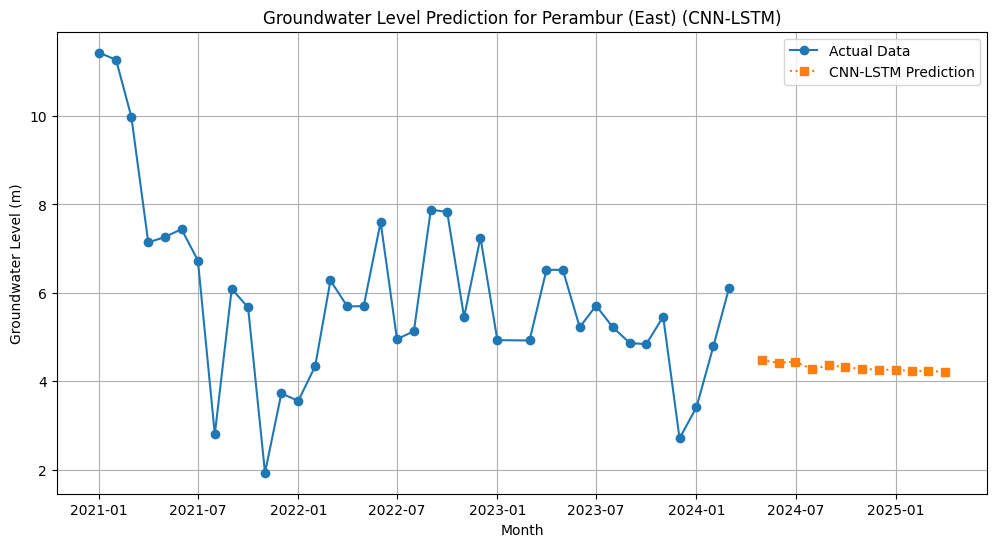

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras_tuner as kt

# File paths for 2021-2024 datasets
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv"
}

# Load all datasets into a single DataFrame
df_list = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df["Year"] = year  # Add Year column
    df_list.append(df)

df_all_years = pd.concat(df_list)

# Fix month column names by stripping spaces
df_all_years.rename(columns=lambda x: x.strip(), inplace=True)

# Updated month list without spaces
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Convert to numeric
df_all_years[months] = df_all_years[months].apply(pd.to_numeric, errors='coerce')

# Select a specific location for forecasting (e.g., Perambur (East))
location = "Perambur (East)"
df_location = df_all_years[df_all_years["Location"] == location][["Year"] + months]

# Reshape into time series format
df_location = df_location.set_index("Year").stack().reset_index()
df_location.columns = ["Year", "Month", "Groundwater Level"]

# Strip extra spaces from Month column values
df_location["Month"] = df_location["Month"].str.strip()

# Convert to datetime
df_location["Date"] = pd.to_datetime(df_location["Year"].astype(str) + "-" + df_location["Month"], format="%Y-%b", errors="coerce")

# Drop any NaN values and set Date as index
df_location = df_location[["Date", "Groundwater Level"]].dropna()
df_location.set_index("Date", inplace=True)

# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_location)

# Prepare Data for CNN-LSTM
sequence_length = 6  # Using last 6 months to predict the next month
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the function to build the model for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Add CNN Layer with hyperparameter tuning for filters and kernel_size
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1), 
                     activation='relu', input_shape=(sequence_length, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Add LSTM Layer with hyperparameter tuning for units
    model.add(LSTM(hp.Int('lstm_units', min_value=50, max_value=150, step=50), activation='relu'))
    
    # Add Dense Layer
    model.add(Dense(1))
    
    # Compile the model with a learning rate that can be tuned
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse')
    
    return model

# Initialize the Hyperband tuner (RandomSearch or Hyperband can be used)
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='cnn_lstm_hyperparameter_tuning'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters: {best_trial.hyperparameters.values}")

# Evaluate the best model
cnn_lstm_preds = best_model.predict(X_test)
cnn_lstm_rmse = np.sqrt(mean_squared_error(y_test, cnn_lstm_preds))
print(f"Best CNN-LSTM RMSE: {cnn_lstm_rmse:.4f}")

# Predict Next 12 Months
future_predictions_cnn_lstm = []
input_seq = X[-1].reshape(1, sequence_length, 1)

for _ in range(12):  # Predict next 12 months
    next_value_cnn_lstm = best_model.predict(input_seq)[0]
    future_predictions_cnn_lstm.append(next_value_cnn_lstm)
    
    input_seq = np.append(input_seq[:, 1:], [[next_value_cnn_lstm]], axis=1)  # Slide window

# Convert back to original scale
future_predictions_cnn_lstm = scaler.inverse_transform(np.array(future_predictions_cnn_lstm).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df_location.index, df_location["Groundwater Level"], marker='o', label="Actual Data")
plt.plot(future_dates, future_predictions_cnn_lstm, marker='s', linestyle="dotted", label="CNN-LSTM Prediction")
plt.xlabel("Month")
plt.ylabel("Groundwater Level (m)")
plt.title(f"Groundwater Level Prediction for {location} (CNN-LSTM)")
plt.legend()
plt.grid()
plt.show()
